# Criteo Click Through Rate Prediction 
Final project for W261 - Machine Learning at Scale  
By Ben Arnoldy, Kenneth Chen, Nick Conidas, Rohini Kashibatla, Pavan Kurapati

Criteo is a company that uses machine learning to serve up web advertising. In 2014, the company launched the [Click Through Rate (CTR) prediction competition](https://www.kaggle.com/c/criteo-display-ad-challenge) hosted on Kaggle. The group with the lowest loss score won. Our team is working on this challenge for our W261 class at UC Berkeley in order to showcase a semester of learning.

## Question 1: Question Formulation  
_Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful._

The overall question we are trying to answer is, given a set of information about a particular website visitor, session, ad, etc., will that visitor click the ad we serve?  
  
A company like Criteo could then use the answer to that question to decide which ad out of a series of possible ads to serve in a particular location during a particular session. Companies like Criteo are paid by advertisers at some rate per user click, so to maximize revenue, Criteo would serve the ad that maximizes (CTR * pay per click). If we can predict CTR accurately -- which is the goal of this competition -- Criteo can find the ad that will maximize their revenue.  
  
This has huge implications because online advertising is a giant industry.  
  
Spending on digital advertising globally is projected to be $327.28 billion in 2019, according to [eMarketer](https://www.emarketer.com/content/global-ad-spending-update).  
  
In order for this machine learning prediction to be useful, it must meet a few criteria:  
  
1. The prediction must happen in a split second. No one wants to wait for webpages to load but this prediction must happen at load time. So algorithm must ingest all the relevant feature data -- info about the user, the session, the ad, etc. -- plug it into the model and return a verdict, and then do that across all potential ads the company can serve, then pick the ad that will maximize revenue and serve it on the page. The pace required immediately rules out learning algorithms like K-Means where you can't pre-train a model. 
2. For companies like Criteo that are serving ads, it doesn't matter all that much _why_ certain ads have higher CTR; it's just crucial to know _which_ ads will. So, interpretability of the model isn't critical here, opening up the range of algorithms to things like neural nets and random forests. Criteo's customers, of course, would love to have an interpretable model so they could make more effective web ads, but that's a different use case.  
3. Web advertising companies are serving a lot of web ad impressions, and most of the time ads go unclicked. And there are a lot of possible features to track in the online space. So we need a lot of data to find something meaningful out of the high-dimensional and sparse data. Fortunately, we have it: the Criteo dataset for this competition has 45 million rows and represents just a week's worth of ad serves. Unfortunately, data on this scale is challenging to work with.
4. Whatever model we train will be quickly out of data given the rapid pace of changes in Internet behavior and the growing amount of data that can be used to improve models. That said, it's not clear that the model needs to be an online model where things are changing so fast that it must update instantly as more data streams in. The model training could happen offline in a matter of hours, even days, and still be okay. DO PEOPLE AGREE WITH THIS LAST POINT? I'M NOT SURE.

## Question 2: Algorithm Explanation
_Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform._  

Logistic regression carries over some of the same concepts as linear regression but with some important differences. Fundamentally, we are still training a model using the equation for a line, and the model is the set of coefficients or weights. 

\begin{equation}\tag{2.1}
y = \beta_0 + \beta_1 \cdot x_1 ... + \beta_m \cdot x_m
\end{equation}
  
\begin{equation}\tag{2.2}
w = [\beta_0, \beta_1, ... \beta_m]
\end{equation}  
  
where $m$ is number of features, $\beta_0$ is the intercept or bias term, and $w$ are the weights of our model.  
  
We aren't training on just one sample, of course, but over many, so the weights are actually calculated over many rows $x$'s and $y$'s.   
  
\begin{equation}\tag{2.3}
y_j = \displaystyle\sum_{i=1}^{m}{w_i\cdot x_{ji} + b}
\end{equation}  
  
where $b$ is the intercept of bias term.  

In vector notation, this can be written:  

\begin{equation}\tag{2.4}
\mathbf{y_j} = \displaystyle{\mathbf{w}^T\mathbf{x}_{j} + b}
\end{equation}  
  
And we can simplify further by including the bias term b into the weights and augmenting the $\mathbf{x}$ vector with a value of 1 that will pass through the bias term as b * 1:

\begin{equation}\tag{2.5}
\mathbf{x}' := 
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
\end{equation}  
  
leaving us with more compact vector equation for the line:  
  
\begin{equation}\tag{2.6}
h(\boldsymbol{\theta}) = \boldsymbol{\theta}^T\mathbf{x}'
\end{equation}
  
As with linear regression, we use this line to make predictions. In linear regression, we take a new datapoint that has a vector of x-values ($\mathbf{x}'$), plug it into the linear equation with our model coefficients ($\boldsymbol{\theta}$), and get a predicted value h(\boldsymbol{\theta}) that falls on the line.  
  
With logistic regression, however, that isn't our final answer. We aren't just trying to get some continuous value y coordinate for our x, we are trying to arrive at a binary classification of a 1 or a 0. 

To do that we must do two additional steps. First, we want to contrain our $h(\boldsymbol{\theta})$ value to the range of $[0,1]$ and do so in a way groups the data more heavily toward either 0 or 1. We do that through a sigmoid function, whose output can be charted like this ([chart source](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)):

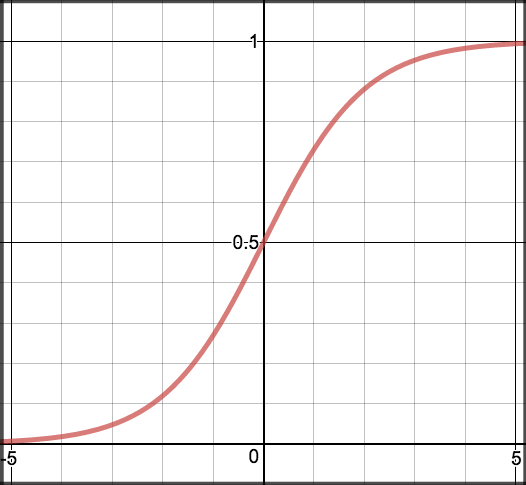

In [1]:
from IPython.display import Image
Image(filename="sigmoid.png", width="400", height="200")

The function for the sigmoid is as follows:  

\begin{equation}\tag{2.7}
P(class=1) = \frac{1} {1 + e^{-z}}
\end{equation}  

where $P(class=1)$ is the probability that our predicted value $z$ should be classified as 1. Again, $z$ is our predicted value, so it can thought of as  $h(\boldsymbol{\theta})$ or $\boldsymbol{\theta}^T\mathbf{x}'$. So we can write this sigmoid function another way:   
  
\begin{equation}\tag{2.8}
P(class=1) = \frac{1} {1 + e^{-\boldsymbol{\theta}^T\mathbf{x}'}}
\end{equation}
  
Equation 2.8 formed the basis for our sigmoid function that we wrote for our toy dataset in section 3 below.  
  
Once we have these probabilities, we need to pick a decision boundary between 0 and 1. One logical default value for that boundary is 0.5. So if the probability is greater than 0.5, classify the sample as 1, otherwise classify it as 0. In chart form, that would look like ([chart source](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)):  

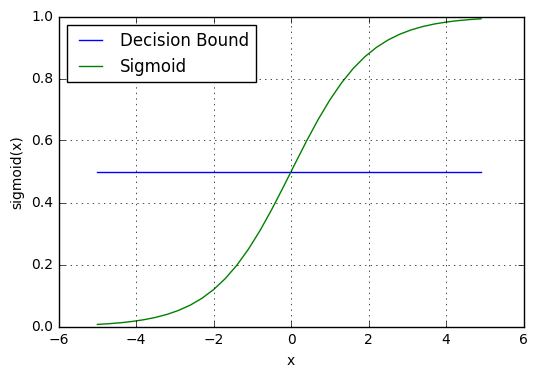

In [2]:
Image(filename="sigmoid_w_threshold.png", width="400", height="200")

And, in mathemathical form, it looks like:  
\begin{equation}\tag{2.9}
p \geq 0.5, class=1 \\
p < 0.5, class=0
\end{equation}

Equation 2.9 formed the basis for our decision_boundary function that we wrote in section 3 for our toy dataset.  
  
Like with linear regression, in order to parallelize the training of the linear model we can't do a closed-form solution but must treat it as an optimization problem with gradient descent. Fortunately, the Log Loss or Cross-Entropy Loss gives us a convex equation, allowing us to use gradient descent with the confidence of not hitting local minima.   
  
The Log Loss function is much like what it sounds: the negative of the log of the prediction value, though there is two versions depending on the actual label value.  
  
\begin{equation}\tag{2.10}
Cost(h_\theta(x),y) = - log(h_\theta(x)), if y=1 \\
Cost(h_\theta(x),y) = - log(1 - h_\theta(x)), if y=0
\end{equation}  
  
We can compile this into a single cost function taking advantage of the fact that we can zero out either side of the equation given $y$ being either 0 or 1 by multiplying one side of the equation by $y$ and another side by $(1-y)$:  

\begin{equation}\tag{2.11}
J(\theta) = - \frac{1}{m}\sum_{i=1}^{m}{[y_i log(h_\theta(x_i)) + (1 - y_i) log(1 - h_\theta(x_i))]}
\end{equation}  

Using equation 2.6 from above ($h(\boldsymbol{\theta}) = \boldsymbol{\theta}^T\mathbf{x}'$), this can be rewritten as:  

\begin{equation}\tag{2.12}
J(\theta) = \frac{1}{m}\cdot(-\mathbf{y}\cdot\boldsymbol{\theta}^T\mathbf{x}' - (1 - \mathbf{y})\cdot log(1 - \boldsymbol{\theta}^T\mathbf{x}')
\end{equation}  

Equation 2.12 forms the basis of our spark job in the LogLoss function that we built for the toy dataset in section 3 below. 

For the gradient, we take the first derivative of this cost function, which winds up being:  
  
\begin{equation}\tag{2.13}
\nabla_\theta f = \mathbf{x}'\cdot(h(\boldsymbol{\theta}) - \mathbf{y}) \\
\nabla_\theta f = \mathbf{x}'\cdot(\frac{1}{1+e^{-\boldsymbol{\theta} \mathbf{x'}}} - \mathbf{y}) \\
\nabla_\theta f = \frac{x}{1+e^{-\boldsymbol{\theta} \mathbf{x'}}} -\mathbf{x}'\mathbf{y} \\ 
\end{equation}  

  
Equation 2.13 forms the basis of our spark job in the GDUpdate_wReg function that we built for the toy dataset in section 3 below.

#### ---------------------------------------------------------------------------------------------------------------------------

## Question 3: EDA

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [121]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numbers

from pyspark.ml.feature import FeatureHasher
from pyspark.sql import SQLContext, Row
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [5]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "fproj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [9]:
# load the data into Spark RDD for convenience of use later (RUN THIS CELL AS IS)
projectRDD = sc.textFile('gs://w261-bucket-pav/notebooks/data/train.txt')

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

In [9]:
average_CTR = projectRDD.map(lambda x: int(x.split('\t')[0])).mean()

In [10]:
average_CTR

0.25622338372976045

### Observation 

Average click through rate is `0.26` which indicates that on average a user will click 25 display ads out of 100 on the webpage. This reflects the poor performance of the display ad. Ideally, we would want near 100% click on display ads. A click through rate of at least 80% will enhance the profits of the display ads. This shows that there are some features critical to the success of the display ad clicks or could be focused on by the advertising team.  

In addition, the in-line lambda function took twice as long as the accumulator function to calculate the average click through rate. 

#### ---------------------------------------------------------------------------------------------------------------------------

In [8]:
# helper function - RUN THIS CELL AS IS
def extractLabel(line):
    """Mapper to extract labels"""
    label = line[0]
    yield label

def extractTrain(line):
    """ Extracts train data"""
    train = line[1:]
    yield train

In [10]:
projectRDD = projectRDD.map(lambda x: x.split('\t')).cache()
# Split the RDD into train, val and test
trainRDD,valRDD,testRDD=projectRDD.randomSplit([0.8, 0.1, 0.1],2019)

In [14]:
print(f"... held out {valRDD.count()} records for validation, {testRDD.count()} records for test and assigned {trainRDD.count()} for training.")

... held out 4585453 records for validation, 4586499 records for test and assigned 36668665 for training.


In [27]:
trainRDD.take(1)

[['0',
  '2',
  '0',
  '44',
  '1',
  '102',
  '8',
  '2',
  '2',
  '4',
  '1',
  '1',
  '',
  '4',
  '68fd1e64',
  'f0cf0024',
  '6f67f7e5',
  '41274cd7',
  '25c83c98',
  'fe6b92e5',
  '922afcc0',
  '0b153874',
  'a73ee510',
  '2b53e5fb',
  '4f1b46f3',
  '623049e6',
  'd7020589',
  'b28479f6',
  'e6c5b5cd',
  'c92f3b61',
  '07c540c4',
  'b04e4670',
  '21ddcdc9',
  '5840adea',
  '60f6221e',
  '',
  '3a171ecb',
  '43f13e8b',
  'e8b83407',
  '731c3655']]

In [24]:
def parse(element):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    n_elements = len(element)
    fields = np.array(element)
    features,click = fields[1:], fields[0]
    return(features, click)

In [25]:
trainRDDCached = trainRDD.map(parse).cache()

In [83]:
# x_arr = trainRDDCached.take(1)[0][0]
# x_arr[13:]
# FIELDS[13:n_features]

In [34]:
n_features = len(trainRDDCached.take(1)[0][0])
n_features

39

In [50]:
integer_labels = ['I'+str(x) for x in range(1,14)]
print(len(integer_labels))
categor_labels = ['C'+str(x) for x in range(1,27)]
categor_labels.append('click')
FIELDS = integer_labels+categor_labels
print(len(FIELDS))

13
40


In [51]:
# Take sample of 1000 trainRDD
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [52]:
sample_df.head(5)
#sample_df = pd.DataFrame(sample[0][0], columns = FIELDS)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,click
0,4,150,1,0,95,12,17,0,2,1,...,0b925d96,,,4f7c2d34,,423fab69,64a2febd,,,1
1,7,6,,1,10,1,7,1,1,1,...,74ef3502,,,e9971827,,423fab69,9117a34a,,,0
2,6,4,1,5,2,3,8,5,9,1,...,0705fb3d,,,65e33bf7,ad3062eb,423fab69,2c1b9978,,,1
3,0,0,,1,3797,279,16,3,83,0,...,d39e7a70,,,a6928003,,bcdee96c,8f079aa5,,,0
4,,0,7,,12634,30,4,0,5,,...,6b7fd522,,,6da32e8e,,32c7478e,07e6f0f8,,,0


In [53]:
sample_df.to_pickle("./sample_df.pkl")

In [ ]:
# Load pickled data
sample_df = pd.read_pickle("./sample_df.pkl")

In [54]:
# Replace all empty strings with np.nan
sample_df = sample_df.replace(r'^\s*$', np.nan, regex=True)
sample_df.head(10)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,click
0,4,150,1,0,95,12,17,0,2,1,...,0b925d96,NaN,NaN,4f7c2d34,NaN,423fab69,64a2febd,NaN,NaN,1
1,7,6,NaN,1,10,1,7,1,1,1,...,74ef3502,NaN,NaN,e9971827,NaN,423fab69,9117a34a,NaN,NaN,0
2,6,4,1,5,2,3,8,5,9,1,...,0705fb3d,NaN,NaN,65e33bf7,ad3062eb,423fab69,2c1b9978,NaN,NaN,1
3,0,0,NaN,1,3797,279,16,3,83,0,...,d39e7a70,NaN,NaN,a6928003,NaN,bcdee96c,8f079aa5,NaN,NaN,0
4,NaN,0,7,NaN,12634,30,4,0,5,NaN,...,6b7fd522,NaN,NaN,6da32e8e,NaN,32c7478e,07e6f0f8,NaN,NaN,0
5,8,11,NaN,2,33,4,38,33,121,2,...,ac2846a6,NaN,NaN,04a420ca,NaN,423fab69,ef218b6e,NaN,NaN,1
6,NaN,3,5,1,299675,NaN,NaN,1,NaN,NaN,...,003d4f4f,NaN,NaN,e587c466,NaN,3a171ecb,3b183c5c,NaN,NaN,0
7,8,1,2,4,53,4,8,4,4,1,...,6fc84bfb,NaN,NaN,4f1aa25f,ad3062eb,423fab69,ded4aac9,NaN,NaN,1
8,NaN,43,87,3,79011,NaN,0,7,3,NaN,...,fb342121,21ddcdc9,5840adea,f6e47def,NaN,c7dc6720,6c1cdd05,ea9a246c,1219b447,0
9,NaN,8,3,2,12175,294,2,2,80,NaN,...,fc16085c,NaN,NaN,c8444cb6,NaN,32c7478e,8940103a,NaN,NaN,0


In [57]:
sample_df[FIELDS[0:13]].isnull().sum()

I1     410
I2       0
I3     227
I4     222
I5      32
I6     198
I7      44
I8       0
I9      44
I10    410
I11     44
I12    777
I13    222
dtype: int64

In [69]:
sample_df[FIELDS[0:13]] = sample_df[FIELDS[0:13]].astype(float)
sample_df.click = sample_df.click.astype(float)

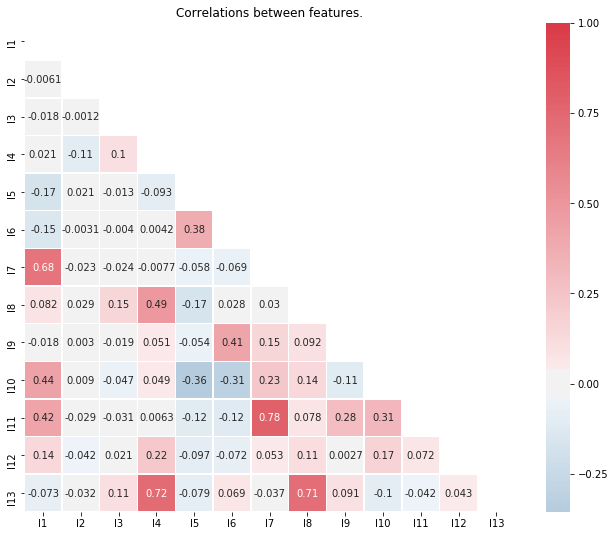

In [59]:
# Correlation between the dependent variables
corr = sample_df[FIELDS[0:13]].corr()
fig,ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

#### I4 & I13, I8 & I13, I7 & I11, I1 & I7 are highly correlated
Since I13 appears twice and correlated with I4 and I8, we can possibly elemenate I13.

In [68]:
#sample_df[FIELDS[0:13]]

In [70]:
# Check correlation with target variable and other integer features
sample_df.drop(FIELDS[13:], axis=1).apply(lambda x: x.corr(sample_df.click))

I1     0.092957
I2     0.017418
I3     0.002890
I4    -0.020240
I5    -0.092118
I6    -0.124801
I7     0.054444
I8    -0.015647
I9    -0.017636
I10    0.153171
I11    0.096868
I12    0.125114
I13   -0.068136
dtype: float64

#### Variables that are least correlated with outcome value are I3, I2, I8, I9

In [72]:
# Convert categorical to one-hot. 
sample_df_onehot = pd.get_dummies(sample_df[FIELDS[13:n_features]])
sample_df_onehot.head(5)

,C1_05db9164,C1_09ca0b81,C1_17f69355,C1_18988050,C1_241546e0,C1_24eda356,C1_255c8173,C1_2d4ea12b,C1_39af2607,C1_3b65d647,...,C26_fa0470cc,C26_fa3124de,C26_fb50b86f,C26_fcd456fa,C26_fda55550,C26_fdf9a32f,C26_fe58998c,C26_ff4e2efb,C26_ff6f8ceb,C26_fffa8e76
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
def n_unique(x):
    """ Counts number of unique values"""
    #If an entry is blank, add them as unique
    total_na = x.isna().sum()
    return x.nunique() + total_na


In [74]:
sample_df[FIELDS[13:n_features]].apply(n_unique,axis=0)

C1      48
C2     198
C3     818
C4     680
C5      23
C6     132
C7     708
C8      42
C9       3
C10    585
C11    578
C12    781
C13    519
C14     15
C15    564
C16    747
C17      9
C18    406
C19    605
C20    497
C21    764
C22    784
C23     12
C24    511
C25    518
C26    794
dtype: int64

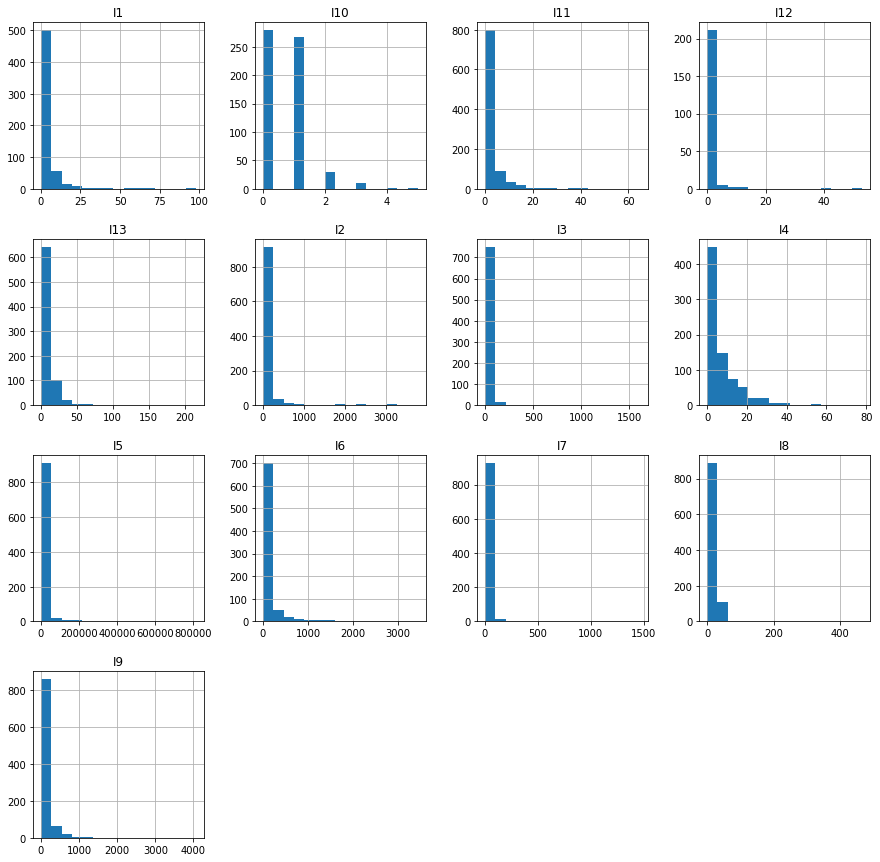

In [75]:
sample_df[FIELDS[0:13]].hist(figsize=(15,15), bins=15)
plt.show()

Variable I5 seem to have major outliers looking at its range

In [99]:
## Distinct values per column on full dataset

def emit_col_val(line):
    features = line[0]
    N = len(features)
    for i in range(13,N):
        yield(i,features[i])

def count_values(line):
    """ Return word count"""
    feature,cat_values = line
    yield (feature,len(cat_values.split()))

catFeatRDD = trainRDDCached.flatMap(emit_col_val)\
                    .distinct()\
                    .reduceByKey(lambda x,y : x+' '+y) \
                    .flatMap(count_values).cache()



In [113]:
catFeat = catFeatRDD.collect()

In [104]:
for i in range(len(catFeat)):
    print('{}: {}'.format(FIELDS[catFeat[i][0]],catFeat[i][1]))

C1: 1460
C2: 579
C3: 8380405
C4: 1884751
C5: 305
C6: 23
C7: 12493
C8: 633
C9: 3
C10: 89036
C11: 5657
C12: 6951577
C13: 3194
C14: 27
C15: 14752
C16: 4590483
C17: 10
C18: 5590
C19: 2166
C20: 3
C21: 5894198
C22: 17
C23: 15
C24: 258633
C25: 104
C26: 133146


Looking at the above, the most valuable categorical variables seem to be C6, C9, C14, C17, C20, C22, C23 as they all have less unique values. A one hot vector of these is much more reasonable than a complete list of categorical values. 

In [114]:
# How many NULL values are there in each integer variable?

def emit_int_feat(line):
    features = line[0]
    N = len(features)
    for i in range(13):
        column = 'I'+str(i+1)
        if features[i]=="":
            yield(column,1)

NullCountRDD = trainRDDCached.flatMap(emit_int_feat)\
                    .reduceByKey(lambda x,y : x+y).cache()

In [133]:
NullCounts = NullCountRDD.collect()
NullCounts

[('I10', 16630341),
 ('I7', 1586483),
 ('I13', 7951100),
 ('I1', 16630341),
 ('I4', 7951100),
 ('I12', 28053144),
 ('I3', 7871130),
 ('I11', 1586483),
 ('I6', 8200470),
 ('I5', 946276),
 ('I9', 1586483),
 ('I8', 18119)]

In [148]:
keys = list(range(1,14))
NullCounts_dict = {key: 0 for key in keys}
for val in NullCounts:
    c = val[0]
    m = val[1]
    c_num = int(c[1:])
    NullCounts_dict[c_num] = m
NullCounts_dict 

{1: 16630341,
 2: 0,
 3: 7871130,
 4: 7951100,
 5: 946276,
 6: 8200470,
 7: 1586483,
 8: 18119,
 9: 1586483,
 10: 16630341,
 11: 1586483,
 12: 28053144,
 13: 7951100}

I2 has no null values. But rest of them have a lot

In [149]:
count = trainRDDCached.count()
keys = list(range(1,14))
NonNullCounts_dict = {key: count for key in keys}
for val in NullCounts:
    c = val[0]
    m = val[1]
    c_num = int(c[1:])
    NonNullCounts_dict[c_num] = count-m
NonNullCounts_dict

{1: 20038324,
 2: 36668665,
 3: 28797535,
 4: 28717565,
 5: 35722389,
 6: 28468195,
 7: 35082182,
 8: 36650546,
 9: 35082182,
 10: 20038324,
 11: 35082182,
 12: 8615521,
 13: 28717565}

In [150]:
# Broadcast the non null counts as we need it to calculate the mean
NonNullCounts_bc = sc.broadcast(NonNullCounts_dict)


In [151]:
NonNullCounts_bc.value

{1: 20038324,
 2: 36668665,
 3: 28797535,
 4: 28717565,
 5: 35722389,
 6: 28468195,
 7: 35082182,
 8: 36650546,
 9: 35082182,
 10: 20038324,
 11: 35082182,
 12: 8615521,
 13: 28717565}

In [187]:
def int_features(line):
    features = line[0]
    label = line[1]
    new_arr = np.array(features[0:13])
    yield((new_arr,label))

IntFeatRDD = trainRDDCached.flatMap(int_features).cache()

In [188]:
IntFeatRDD.take(1)

[(array(['2', '0', '44', '1', '102', '8', '2', '2', '4', '1', '1', '', '4'],
        dtype='<U8'), '0')]

In [137]:
count

36668665

In [152]:
# It could be better to replace the null values with their mean in the integer variables. Calculate mean per column
def emit_int_features(line):
    features = line[0]
    for i in range(len(features)):
        column = i+1
        if features[i]!="":
            yield(column,float(features[i]))
def emit_mean(x):
    column = int(x[0])
    total = x[1]
    #mean_val = total/36668665
    mean_val = total/NonNullCounts_bc.value[column]
    yield(column,mean_val)

mean_values = IntFeatRDD.flatMap(emit_int_features)\
                    .reduceByKey(lambda x,y : x+y)\
                    .flatMap(emit_mean).collect()

In [153]:
mean_values

[(1, 3.502003211446227),
 (2, 105.87023119058193),
 (3, 26.867957309540557),
 (4, 7.322189224608702),
 (5, 18541.008691999854),
 (6, 116.11255553785548),
 (7, 16.340429708733623),
 (8, 12.517188093186933),
 (9, 106.12212378922155),
 (10, 0.6174176043864746),
 (11, 2.7336556488989197),
 (12, 0.9915184467660169),
 (13, 8.21731170452648)]

In [154]:
mean_dict = dict()
for val in mean_values:
    c = val[0]
    m = val[1]
    mean_dict[c] = m

mean_dict    

{1: 3.502003211446227,
 2: 105.87023119058193,
 3: 26.867957309540557,
 4: 7.322189224608702,
 5: 18541.008691999854,
 6: 116.11255553785548,
 7: 16.340429708733623,
 8: 12.517188093186933,
 9: 106.12212378922155,
 10: 0.6174176043864746,
 11: 2.7336556488989197,
 12: 0.9915184467660169,
 13: 8.21731170452648}

In [156]:
# Broadcast the mean dictionary. We need it to replace null values later
mean_dict_bc = sc.broadcast(mean_dict)


In [155]:
x = np.array([1,2,3,4,5,6,7,'',9,10,'',12,13])
for i in range(13):
    if x[i] == '':
        x[i] = mean_dict[i+1]

x        

array(['1', '2', '3', '4', '5', '6', '7', '12.517188093186933', '9', '10',
       '2.7336556488989197', '12', '13'], dtype='<U21')

OK, Now we have means for every integer variable. We also know what categorical variables needs to be discarded. We need to now prepare train data

Let us first drop the other categorical values and only maintain the ones we are interested

In [197]:
def remove_categorical(x):
    features = x[0]
    label = x[1]
    # We are interested in C6,C9, C14, C17, C20, C22, C23
    # These are at index 18,21,26,29,32,34,35
    c_index_list = [18,21,26,29,32,34,35]
    new_arr = np.array(features[0:13],dtype=str)
    for index in c_index_list:
        new_arr = np.append(new_arr,features[index])
    yield((new_arr,label))

new_trainRDDCached = trainRDDCached.flatMap(remove_categorical).cache()

In [198]:
new_trainRDDCached.take(1)

[(array(['2', '0', '44', '1', '102', '8', '2', '2', '4', '1', '1', '', '4',
         'fe6b92e5', 'a73ee510', 'b28479f6', '07c540c4', '5840adea', '',
         '3a171ecb'], dtype='<U8'), '0')]

In [212]:
# Replace all blanks in new_trainRDDCached integer values with their means

def replace_int_null(x):
    features = x[0]
    label = int(x[1])
    for i in range(13):
        if features[i]=="":
            features[i] = float(mean_dict_bc.value[i+1])
        else:
            features[i] = float(features[i])
    features = features.astype(float)
    yield((features,label))

def replace_int_null_noInt(x):
    features = x[0]
    label = int(x[1])
    for i in range(13):
        if features[i]=="":
            features[i] = float(mean_dict_bc.value[i+1])
        else:
            features[i] = float(features[i])
    yield((features,label))
    
def replace_char_null(x):
    features = x[0]
    label = int(x[1])
    for i in range(13,len(features)):
        if features[i]=="":
            features[i] = 'AAAA'
    yield((features,label))
    

In [213]:
new_trainRDDCached = new_trainRDDCached.flatMap(replace_int_null_noInt)\
                                    .flatMap(replace_char_null).cache()
new_trainRDDCached.take(1)

[(array(['2.0', '0.0', '44.0', '1.0', '102.0', '8.0', '2.0', '2.0', '4.0',
         '1.0', '1.0', '0.991518', '4.0', 'fe6b92e5', 'a73ee510',
         'b28479f6', '07c540c4', '5840adea', 'AAAA', '3a171ecb'],
        dtype='<U8'), 0)]

In [214]:
IntFeatRDD = IntFeatRDD.flatMap(replace_int_null).cache()
IntFeatRDD.take(1)

[(array([  2.      ,   0.      ,  44.      ,   1.      , 102.      ,
           8.      ,   2.      ,   2.      ,   4.      ,   1.      ,
           1.      ,   0.991518,   4.      ]), 0)]

### Helper functions from HW4

In [217]:
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    normedRDD = dataRDD.map(lambda x: (np.divide((x[0] - featureMeans), featureStdev), x[1]))        
    return normedRDD

In [218]:
normedRDD = normalize(IntFeatRDD).cache()

In [215]:
def logisticRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0][0])
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1 / (1 + np.exp(-p[1]*np.dot(wBroadcast.value, p[0])))-1) * p[1] * np.array(p[0]))\
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

In [219]:
logisticRegressionGDReg(normedRDD, iterations=50, regParam=0.1, regType="Lasso")

array([-0.28885354, -1.60980304,  0.80743505, -0.44989991, -0.21066663,
       -0.6962895 ,  1.03753076, -0.75741466, -1.7196937 ,  0.87799881,
        0.56053184, -0.58950019, -1.01975126])

#### With L1 Norm

In [220]:
# Log loss function
# adapted from HW4 and https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

def LogLoss(dataRDD, W):
    """
    Compute log loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))

#    loss = augmentedData.map(lambda x: (-x[1]*np.log(1 / (1 + np.exp(-np.dot(W, x[0])))) -\
#                                        (1-x[1])*np.log(1- (1 / (1 + np.exp(-np.dot(W, x[0]))))), 1)) \
# NOT SURE ABOUT MINUS SIGN IN MIDDLE, AND TO SOME DEGREE AT START
    loss = augmentedData.map(lambda x: (-np.dot(x[1],np.log(1 / (1 + np.exp(-np.dot(W, x[0]))))) -\
                                        np.dot((1-x[1]),np.log(1- (1 / (1 + np.exp(-np.dot(W, x[0])))))), 1)) \
                        .reduce(lambda x,y:(x[0]+y[0], x[1]+y[1]))

    loss = float(loss[0])/loss[1]
    
    return loss

In [227]:
# Update the gradient
# Adapted from HW4 and https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/r20ff7q0yni5kiu/LogisticRegression-Spark-Notebook.ipynb

def GDUpdate_wReg(dataRDD, W, N, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    
    # calculate the gradient
    
    gradient = augmentedData.map(lambda x: (1 / (1 + np.exp(-x[1]*np.dot(W, x[0])))-1) * x[1] * np.array(x[0]))\
                    .reduce(lambda x, y: x + y)
    if regType == "ridge":
        wReg = W * 1
        wReg = np.append([0], wReg[1:]) # remove the bias term ahead of regularization        
    elif regType == "lasso":
        wReg = W * 1
        wReg = np.append([0], wReg[1:]) # remove the bias term ahead of regularization
        wReg = (wReg>0).astype(int) * 2-1
    else:
        wReg = np.zeros(W.shape[0])
    gradient = gradient + regParam * wReg  #gradient:  GD of Squared Error+ GD of regularized term 
    new_model = W - learningRate * gradient / N

    return new_model

In [248]:
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = True):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # calculate N here so you don't have to do it in the for looped function call
    N = trainRDD.count()

    # make a starter set of weights if none provided
    featureLen = len(trainRDD.take(1)[0][0])
    if wInit is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInit
    model = w
    
    # perform nSteps updates & compute test and train loss after each
    for idx in range(nSteps):  
   
        # update the model
        model = GDUpdate_wReg(trainRDD, model, N, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        training_loss = LogLoss(trainRDD, model)
        test_loss = LogLoss(testRDD, model)
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [260]:
featureLen = len(normedRDD.take(1)[0][0])
#wInit = np.random.normal(size=featureLen)
wInit = np.array([-0.77, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0])
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.1)
print(f"\n... trained {len(lasso_results[2])} 50 iterations in {time.time() - start} seconds")


... trained 50 50 iterations in 5470.488104104996 seconds


In [261]:
# make error curve plots that show declining loss as walk down the gradient
# from HW4 code

def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of log loss) , testLoss (list of log loss)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()

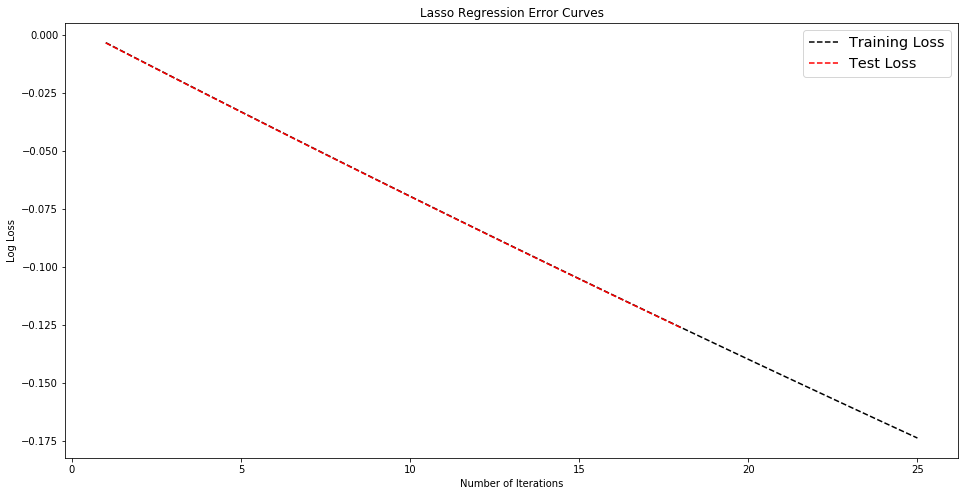

In [262]:
trainLoss, testLoss, models = lasso_results
lasso_models = np.array(models)
#np.savetxt('gs://w261-bucket-pav/notebooks/lasso_models.csv', np.array(models), delimiter=',')
#np.savetxt('gs://w261-bucket-pav/notebooks/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

In [263]:
#lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_lasso = lasso_models[-1,:]

In [257]:
best_lasso

array([ 1.92124278,  0.03221918,  0.04965427,  0.0157926 , -0.06172262,
       -0.1540008 , -0.13814007,  0.04112475, -0.07455633,  0.00194255,
        0.13475442,  0.17291475,  0.04612588, -0.12015327])

In [264]:
# Now that we have the schema corrected, create some feature grouping lists for easy data manipulation
numeric_features = ["I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", "I10", "I11", "I12", "I13"]
categorical_features = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12",\
                        "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23",\
                       "C24", "C25", "C26"]
label_and_numeric = ["label"] + numeric_features

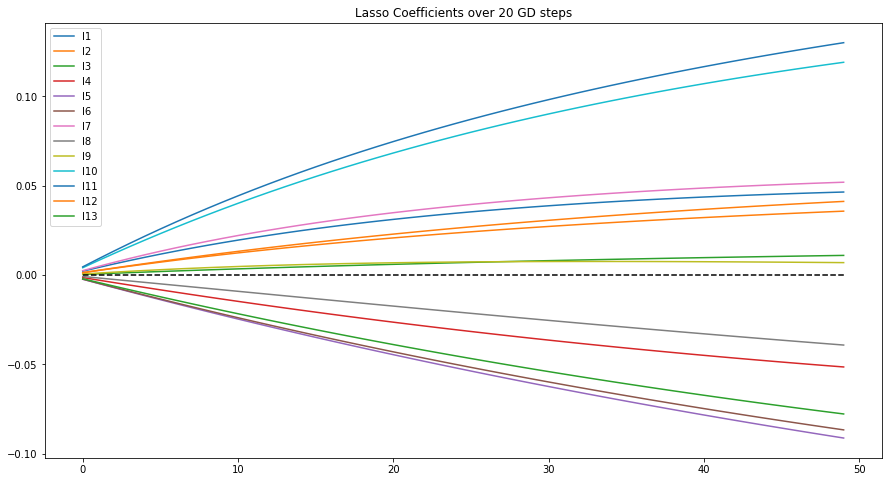

In [265]:
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show
    
# use if starting with the models with the missing data features
#plotCoeffs(lasso_models, ['Bias'] + numeric_features + missing, "Lasso Coefficients over 50 GD steps")

# use if starting with the model where NA rows were dropped
plotCoeffs(lasso_models, ['Bias'] + numeric_features, "Lasso Coefficients over 20 GD steps")

In [266]:
def sigmoid(row):
    sig = []
    for z in row:
        sig.append(1/(1+np.exp(-z)))
    return sig

def decision_boundary(prob):
    return 1 if prob >= .5 else 0

def classify(predictions):
    '''
    input  - N element array of predictions between 0 and 1
    output - N element array of 0s (False) and 1s (True)
    '''
    classifications = []
    for prediction in predictions:
        classifications.append(decision_boundary(prediction))
    return classifications

def calc_accuracy(predicted_labels, actual_labels):
    error_count = 0
    num_predictions = len(actual_labels)
    for compare in range(num_predictions):
        if predicted_labels[compare] != actual_labels[compare]:
            error_count += 1
    return 1.0 - (float(error_count) / num_predictions)

def compare(x,y):
    return int(x != y)

coeffs = best_lasso[1:] # coefficients
b = best_lasso[0] # bias term
actual_labels = testRDD.map(lambda x: x[1]).collect()

# spark version
#error_count = testRDD.map(lambda x: (np.dot(coeffs, x[0])+b, x[1])) \
#                    .map(lambda x: (1/(1+np.exp(-x[0])), x[1])) \
#                    .map(lambda x: (decision_boundary(x[0]), x[1])) \
#                    .map(lambda x: (compare(x[0],x[1]),1)) \
#                    .reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]))
#
#print("accuracy is", 1.0 - (float(error_count[0]) / error_count[1]))
# regular version
mxb = testRDD.map(lambda x: np.dot(coeffs, x[0])+b).collect() # mx+b
probabilities = sigmoid(mxb) # put through sigmoid
predictions = classify(probabilities) # put through a decision boundary
print ("accuracy is", calc_accuracy(predictions, actual_labels))

accuracy is 0.6579554403854118


## Question 2: Algorithm Explanation
Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform.  

Logistic regression carries over some of the same concepts as linear regression but with some important differences. Fundamentally, we are still training a model that results in an equation for a line. So our trained model looks like a vector of coefficients in a linear equation:  
  
<center>Linear equation: $y = \beta_0 + \beta_1 \cdot X_1 ... + \beta_m \cdot X_m$</center>    
  
<center>Our model: $[\beta_0, \beta_1, ... \beta_m]$</center>    
where m is number of features and $\beta_0$, or intercept, is a bias term.  
As with linear regression, we use this line to make predictions. In linear regression, we take a new datapoint of features (x's), plug into the linear equation with our model coefficients, and get a predicted y value. With logistic regression, it's more complicated since we are taking continuous variable inputs and trying to arrive at a binary classification output. The line we are drawing is a decision boundary above which we classify the input as 1 and below which we classify the input as 0. We need to perform some additional steps to convert the y value prediction, which is a continuous variable, to a final answer of a 0 or a 1. First, we put the predicted y value through a sigmoid function, which outputs a continuous value between 0 and 1 that represents a probability:  
  
<center>P(class=1) = \frac{1} {1 + e^{-z}}</center>
  
where z is the y value prediction (i.e. mx+b).  Once we have these probabilities, we need to pick a decision boundary between 0 and 1. One logical default value for that boundary is 0.5. So if the probability is greater than 0.5, classify the sample as 1, otherwise classify it as 0.  
  
Like with linear regression, in order to parallelize the training of the linear model we can't do a closed-form solution but must treat it as an optimization problem with gradient descent. Fortunately, the Log Loss or Cross-Entropy Loss method described above gives us a convex equation, allowing us to use gradient descent with the confidence of not hitting local minima.  
  
Objective: $f(w) = \sum_{i=1}^{n}log(1+exp(-y_i w^T x_i))$  
$\frac{df}{dw} = \sum_{i=1}^{n}\frac{1}{1+exp(-y_i w x_i)}\cdot\frac{d[1+exp(-y_i w x_i)}{dw}$  
$              = \sum_{i=1}^{n}\frac{exp(-y_i w x_i)}{1+exp(-y_i w^T x_i)}\cdot\frac{d(-y_i w x_i)}{dw}$  
$              = \sum_{i=1}^{n}\frac{exp(-y_i w x_i)}{1+exp(-y_i w^T x_i)}(-y_i x_i)$  
$              = \sum_{i=1}^{n}[1 - \frac{1}{1+exp(-y_i w x_i)}](-y_i x_i)$  
$              = \sum_{i=1}^{n}[\frac{1}{1+exp(-y_i w x_i)} + 1](y_i x_i)$  
$  \nabla_w f =\sum_{i=1}^{n}[\frac{1}{1+exp(-y_i w^T x_i)} + 1](y_i x_i)$
  
This gets expressed in the code below as a spark job as follows:  
.map(lambda x: (1 / (1 + np.exp(-x[1]*np.dot(W, x[0])))-1) * x[1] * np.array(x[0]))  
.reduce(lambda x, y: x + y)

A LITTLE BIT MORE ON THE CALCULATING LOSS...

  











#### EDA: See correlations

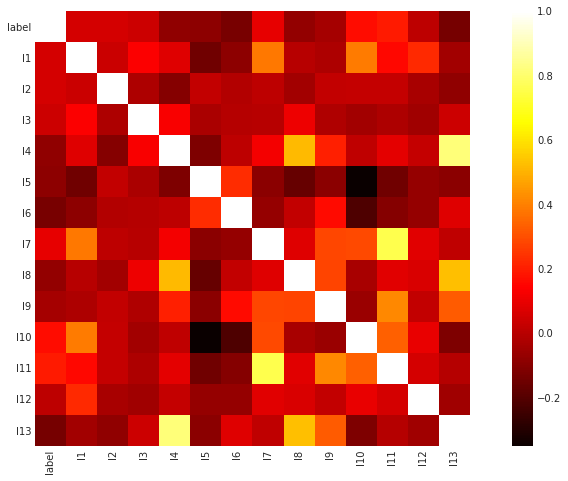

In [103]:
# Correlation heat map on integer features and label
# Turn your settings on Jupyter to white background
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
plt.imshow(numericPDF.corr(), cmap='hot', interpolation='nearest')
plt.colorbar()
labels = numericPDF.columns.tolist()
ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,rotation=90, fontsize=10)
ax1.set_yticklabels(labels,fontsize=10)
plt.show()

#### Observations from the correlation heatmap
1. Nothing seems all that correlated with the label. Best are I7, I10, I11
2. There are some features strongly correlated with outher features: (I7,I11), (I4, I13), (I4, I8), (I8, I13)

In [238]:
# Try doing chi-squared test for categorical features and the label
# relied on code from here: https://codereview.stackexchange.com/questions/96761/chi-square-independence-test-for-two-pandas-df-columns

factorizedPDF = samplePDF[label_and_numeric]
for colname in categorical_features:
    factorizedPDF[colname] = pd.factorize(samplePDF[colname])[0]
    
import scipy.stats as scs

def categories(series):
    return range(int(series.min()), int(series.max()) + 1)

def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]
    
    # can't have cells in contigency table <5, so tossing out small categories
    # valid if just trying to get a rough idea of associations? hopefully...
    new_cont_table = []
    for pair in result:
        if (pair[0] >= 5 and pair[1] >= 5):
            new_cont_table.append(pair)
    
    if (new_cont_table == []): 
        return None
    else:
        return scs.chi2_contingency(new_cont_table)

print("Chi_square test on each categorical column with label\n")
for colname in categorical_features:
    if chi_square_of_df_cols(factorizedPDF, colname, 'label') != None:
        p_val = chi_square_of_df_cols(factorizedPDF, colname, 'label')[1]
        print(colname, "p-value: ", p_val)
    else:
        print(colname, "p-value: None")


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Chi_square test on each categorical column with label

C1 p-value:  0.21082798547288253
C2 p-value:  0.6435562286680369
C3 p-value:  1.0
C4 p-value:  0.012948939934941228
C5 p-value:  0.8535936414496317
C6 p-value:  0.049581973659291234
C7 p-value:  0.797861519994188
C8 p-value:  0.6135336372023791
C9 p-value:  7.50591017192037e-05
C10 p-value:  1.0
C11 p-value:  0.7938565664416881
C12 p-value:  1.0
C13 p-value:  0.6702820959999762
C14 p-value:  0.0004643180576810328
C15 p-value: None
C16 p-value:  0.010838360359114419
C17 p-value:  6.215519829380432e-06
C18 p-value:  0.36916060790189564
C19 p-value:  0.4073140424351105
C20 p-value:  0.3279960391349751
C21 p-value:  0.010838360359114419
C22 p-value:  0.3632684079519511
C23 p-value:  0.2132366139150885
C24 p-value:  0.7881904129396066
C25 p-value:  0.3848364145236987
C26 p-value:  0.4419905004244705


#### Results of the chi-squared correlation tests on categories
C4, C6, C9, C14, C16, C17, C21 appear to show significant correlation

## Algorithm Explanation

This is the fundamental concept in feature engineering when exploring our Criteo dataset. 

## Data Exploration 

```
  45,840,617 (Criteo dataset in Kaggle) 
      |
      |
   100,000 (sample) 
    |-- train data      : 80,000 (80%) 
    |-- validation data : 10,000 (10%)
    |-- test data       : 10,000 (10%)
```

Initially, we will explore 100,000 sample dataset out of original 45 million samples. To test the performance of our classifiers, we split 80% of the sample dataset into train data (80,000), 10% into validation data (10,000) and the remaining 10% for the final test data (10,000). 

## Features Engineering (One Hot Encoding Vs Features Hashing) 

Each sample has `40` variables. The first variable or the column is the label: `1` or `0` to indicate the clicking event, `1` being the clicked activity. The remaining `39` variables are features, of which `13` are represented in numeric value and the rest `26` are represented in hashed value. Some of them have missing values. All features are categorical features. In order to capture all the features, we will explore the most common feature engineering methods for categorical variables: **one hot encoding (OHE)** and **feature hashing**. 

### 1. One Hot Encoding (OHE)

As the name suggests, one hot encoding (OHE) expands all the unique features in the dataset. 

```
|         | feature1 | feature2 | feature3 | 
|---------|----------|----------|----------|
|sample 1 | black    | round    | matte    |
|sample 2 | white    | square   | shiny    |
|sample 3 | blue     | round    | matte    |
|sample 4 | black    | round    | shiny    | 


|         |black |white |blue ||round |square ||matte  |shiny | 
|---------|------|------|-----||------|-------||-------|------|
|sample 1 | 1    | 0    | 0   || 1    |  0    || 1     | 0    |  
|sample 2 | 0    | 1    | 0   || 0    |  1    || 0     | 1    |
|sample 3 | 0    | 0    | 1   || 1    |  0    || 1     | 0    | 
|sample 4 | 1    | 0    | 0   || 1    |  0    || 0     | 1    | 


index    = [0, 1, 2, 3, 4, 5, 6]
--------------------------------
sample 1 = [1, 0, 0, 1, 0, 1, 0] 
sample 2 = [0, 1, 0, 0, 1, 0, 1]
sample 3 = [0, 0, 1, 1, 0, 1, 0]
sample 4 = [1, 0, 0, 1, 0, 0, 1]
```

The advantage of one hot encoding is when the dataset is relatively small, it is convenient to capture all the unique features. We can also create a sparse vector to represent our dataset in more compact fashion. However one hot encoding becomes computationaly expensive when the dataset is extremely large, for eg, our Criteo Kaggle dataset which comes with 45 millions of samples and there are at least 33 millions unique features. 

The other disadvantage of One Hot Encoding is, in order to capture all the unique features, we need to have a single pass over the entire dataset, which makes the computation more expensive for the large data. However we will use OHE in our exploratory data analysis and compare with features hashing method described below. 

In [8]:
# I changed the sampleRDD into trainRDD but left the `sampleRDD1` name intact 
# because I don't want to change all other variable name.

sampleRDD1 = trainRDD.map(lambda x: x.replace('\t', ','))

# Splitting the data
# I'm splitting the original 45 million data,
weights = [0.7, 0.15, 0.15]
seed = 42
# Use randomSplit with weights and seed
TrainData, ValData, TestData = sampleRDD1.randomSplit(weights,seed)

# count the data
nTrain = TrainData.count()
nVal = ValData.count()
nTest = TestData.count()
print("Number of train data: ", nTrain)
print("Number of val data  : ", nVal)
print("Number of test data : ", nTest)
print("number of total data: ", nTrain + nVal + nTest)
print(sampleRDD1.take(1))

Number of train data:  32085274
Number of val data  :  6876749
Number of test data :  6878594
number of total data:  45840617
['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


## Question 4: Algorithm Implementation

This is a step by step walk through on how we develop home grown algorithm with particularly a parallel computation concept in mind. Since our dataset is very large, in order to capture all the unique features, we first employed one hot encoding approach for our small dataset `100,000` samples. 

## Step by step walk through to create one hot encoding

One sample 
```
['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']
```
### Step 1 (Features selection) 

Remove the first column, i.e., label `1` or `0`. 

```
['0']
[1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']
```

### Step 2 (Index each feature)

Assign the remaining `39` variables with corresponding indexes. This step is critical because we will then use the index as our keys and in the reducer step, we could count how many unique features exists in each index.  

```
[[(0, '1'),      # index 0, feature 1 with the category '1'
  (1, '1'),
  (2, '5'),
  (3, '0'),
  (4, '1382'), ...],
 [(0, '5'),      # index 0, feature 1 with the category '5'
  (1, '10'), 
  (2, '34'), ...], ...,
  []]
```

### Step 3 (Select unique) 

The index `0` can have many features. For example 

```
(0, '1')
(0, '5')
(0, '15')
(0, '8')
(0, '1')      --> (already had above), will be removed by distinct()
(0, '15')     --> (already had above), will be removed by distinct() 
...
```
To count the unique features for each index, we will use `distinct()`. Distinct() step will be expensive especially when the data is very large. 

### Step 4 [Optional] (Mapper and Reducer stage) 

1. Map every index and emit them with `1` so that we can reduce them. 
2. Reduce by (lambda x, y: x + y) 

```
[(0, 145),
 (1, 2483),
 (2, 864),
 (3, 130),
 (4, 20352),
 ...
```

There are 145 unique categories for the index `0`, which is the first feature out of `39` features in our sample. 

### Step 4 (Create One Hot Dictionary) 

We need to create an index dictionary for all the unique features. Once we have the dictionary, we then go over all the samples and create a sparse vector based on what features each sample has. 

```
1. zipWithIndex() will create an index for every items
2. The emitted from above will become the tuple with the index starting from `0`.
3. [((0, '1'), 0), ((4, '1382'), 1), ((7, '2'), 2), ((13, '68fd1e64'), 3), ((14, '80e26c9b'), 4), ...]
4. collectAsMap() will create a dictionary by mapping the first [0] in a tuple and makes them as keys (composite key)
5. the index becomes the dict value

{(0, '1'): 0,
 (4, '1382'): 1,
 (7, '2'): 2,
 (13, '68fd1e64'): 3,
 ...,
 ...,
 (36, '9a1c7e3d'): 234358}
```

### Step 5 (One Hot Encoding) 

In order to pipeline our RDD into our classifiers in later steps. Spark has a LabeledPoint which requires label in its tuple index`[0]` position. the index`[1]` has the sparse vector format. Reference <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=labeledpoint">here</a>. This is what we try to achieve from our RDD sample. 

```
[LabeledPoint(0.0, (234358,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,117215,117216,117217,117218,117219,117220,117221,117222,117223,117224,117225,117226,117227,117228,117229,117230,117231,117232,117233,117234,117235],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))] 
```
1. The first `0.0` at tuple index`[0]` is the sample label. 
2. `234358` is the length of the vector space. 
3. The first list `[]` is the index list for all the unique features for the sample. 
4. The second list `[]` is the value of the unique features. Since this is OHE, it's `1`. 


- To achieve this, we need to feed our original RDD because we need the original label for each sample. 
- To have the sparse vector, we already created OHE dictionary in Step 4. We will then create our sample into `(index, category)` format, and search in our OHE dictionary for their corresponding index.  

## Step 6 (Classifiers) 

We will use logistic regression because our label is a binary classification, either `1` or `0`. We will use log loss function as to check our model performance. A general rule of thumb is the nearer the log loss value is to zero, the more accurate our model is. 

In [38]:
def indexFeatures(line):
    #  select feature of interest after removing the first column which is the label

    features = []

    for index,feature in enumerate(line.split(',')[1:]):
        idxFeat = index,feature
        features.append(idxFeat)
        
    return features

In [12]:
# This is indexing all the features 

start = time.time()

indexedTrainFeat = TrainData.map(indexFeatures)

totalCat = (indexedTrainFeat
            .flatMap(lambda x: x)
            .distinct()
            .map(lambda x: (x[0], 1))
            .reduceByKey(lambda x, y: x + y)
            .sortByKey()
            .collect())

print(totalCat)
print("Time taken : {} seconds".format(time.time() - start))

[(0, 140), (1, 2378), (2, 813), (3, 127), (4, 18849), (5, 1817), (6, 560), (7, 123), (8, 1724), (9, 8), (10, 84), (11, 65), (12, 244), (13, 457), (14, 491), (15, 32275), (16, 19453), (17, 127), (18, 11), (19, 6977), (20, 219), (21, 3), (22, 9243), (23, 3593), (24, 30531), (25, 2700), (26, 26), (27, 4643), (28, 25973), (29, 9), (30, 2325), (31, 1174), (32, 4), (33, 28682), (34, 10), (35, 14), (36, 10034), (37, 49), (38, 7717)]
Time taken : 4.247509479522705 seconds


In [112]:
# [features_list[i] for i in [1, 2, 4, 5, 8, 15, 16, 19, 22, 23, 24, 27, 28, 30, 31, 33, 36, 38]]   --> logloss 0.505 on test
# [features_list[i] for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]                           --> logloss 0.485 on test
# [features_list[i] for i in range(14, 39)]               # categorical features                    --> logloss 0.531 on test
# [features_list[i] for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 19, 27, 29, 34]]       --> logloss 0.520 on test
def selectFeatures(line):
    #  index each feature after removing the first column which is the label

    features = []

    features_list = line.split(',')[1:]
    selected_features = [features_list[i] for i in [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 
    for index,feature in enumerate(selected_features):
        idxFeat = index,feature
        features.append(idxFeat)
        
    return features

In [113]:
# This is selecting features which have more than 1000 unique categories in each feature

start = time.time()

indexedTrainFeat = TrainData.map(selectFeatures)

totalCat = (indexedTrainFeat
            .flatMap(lambda x: x)
            .distinct()
            .map(lambda x: (x[0], 1))
            .reduceByKey(lambda x, y: x + y)
            .sortByKey()
            .collect())

print(totalCat)
print("Time taken : {} seconds".format(time.time() - start))

[(0, 8741), (1, 450), (2, 424238), (3, 10553), (4, 3790), (5, 1196), (6, 6731), (7, 13), (8, 166), (9, 376), (10, 1161)]
Time taken : 201.2898724079132 seconds


In [114]:
# Counting total number of categories
start = time.time()
total = 0
for item in totalCat:
    total += item[1]
print("Total number of unique categories for all features: ", total)
print("Time taken : {} seconds".format(time.time() - start))

Total number of unique categories for all features:  457415
Time taken : 0.0005197525024414062 seconds


#### Unique features analysis 

1. There are `28,728,198` unique features extracted from the train dataset 0.8 * 45 = 36 million dataset using one hot encoding. Since it crashes in the later step, I reduced  the training dataset into 0.5 * 45 = 22.5 million dataset, which gave us `19,733.119` unique features. Since the computer crashes, I further reduced the training size to `4.1` million dataset. 

In [43]:
def createOHEDict(dataRDD):
    """ This is an function to create one hot encoding (OHE) dictionary 
    on the entire dataset. To make sure there's a unique number of categories for each feature,
    it will use the distinct() function. """
    
    OHEDict = (dataRDD.map(indexFeatures)
                       .flatMap(lambda x: x)
                       .distinct()
                       .zipWithIndex()
                       .collectAsMap())
    return OHEDict

In [115]:
# Creating OHEDict for selected features only 

def createOHEDict(dataRDD):
    """ This is an function to create one hot encoding (OHE) dictionary 
    on the entire dataset. To make sure there's a unique number of categories for each feature,
    it will use the distinct() function. """
    
    OHEDict = (dataRDD.map(selectFeatures)
                       .flatMap(lambda x: x)
                       .distinct()
                       .zipWithIndex()
                       .collectAsMap())
    return OHEDict

In [116]:
start = time.time()
trainOHEDict = createOHEDict(TrainData)
print("The value of (1, '') is ", trainOHEDict[(1, '')])
print("Time taken to process : {} seconds".format(time.time() - start))

trainOHEFeatures = len(trainOHEDict.keys())
print(trainOHEFeatures)

The value of (1, '') is  111430
Time taken to process : 201.84091520309448 seconds
457415


## I. One Hot Encoding 
## Preparing each dataset for our classifier model

In [117]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

def sparseOHE(feature_list, OHEDict):
    """Emitting SparseVector from the entire one hot encoding dictionary 
    for one sample data at a time
    """

    index_list = []
    
    for feat in feature_list:
        if feat in OHEDict:                     # this step is for other dataset when the unique feature might not be in the OHE dict
            index_list.append(OHEDict[feat])
        
    index_list.sort()
    
    # create a list of 1.0s for each feature
    values = [1.] * len(index_list)

    return SparseVector(len(OHEDict.keys()), index_list, values)

def parseRDD(line, OHEDict):
    """emit label, sparseVector for the sample that has been already one hot encoded. 
    label = 1 or 0 
    sparseVector = (total number of features, [list of indexes], [list of corresponding values])
    """
    features = []
    
    # split each value in the comma separated text
    for index, feature in enumerate(line.split(',')[1:]):
        idxfeat = index, feature
        features.append(idxfeat)
    
    return LabeledPoint(line.split(",")[0], sparseOHE(features, OHEDict))

In [118]:
start = time.time()
OHETrainData = TrainData.map(lambda line: parseRDD(line, trainOHEDict))
OHEValData = ValData.map(lambda line: parseRDD(line, trainOHEDict))
OHETestData = TestData.map(lambda line: parseRDD(line, trainOHEDict))
print("1st sample of feature engineered train data")
print(OHETrainData.take(1))
print("-"*50)
print("1st sample of feature engineered validation data")
print(OHEValData.take(1))
print("-"*50)
print("1st sample of feature engineered test data")
print(OHETestData.take(1))
print("-"*50)
print("Time taken to process for 3 datasets: {} seconds".format(time.time() - start))

1st sample of feature engineered train data
[LabeledPoint(0.0, (457415,[37123,72997,119774,123793,160964,182272,241862,329322,405360,409442,447770],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
--------------------------------------------------
1st sample of feature engineered validation data
[LabeledPoint(0.0, (457415,[37123,78462,104587,127918,305271,392966,399792,430048,453286],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
--------------------------------------------------
1st sample of feature engineered test data
[LabeledPoint(0.0, (457415,[138951,143065,199461,251540,276224,317476,366934,392966],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
--------------------------------------------------
Time taken to process for 3 datasets: 20.27706527709961 seconds


## Classifiers
## Logistic Regression on Criteo CTR Data




In [119]:
# Model definition

from pyspark.mllib.classification import LogisticRegressionWithSGD

# adjustable hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

model0 = LogisticRegressionWithSGD.train(OHETrainData,\
                                         iterations=numIters,\
                                         step=stepSize,\
                                         regParam=regParam,\
                                         regType=regType,\
                                         intercept=includeIntercept)

print("Model weights for the first 5 variables or features developed on train data\n")
sortedWeights = sorted(model0.weights)
print(sortedWeights[:5])
print("-"*50)
print("Model intercept\n")
print(model0.intercept)

Model weights for the first 5 variables or features developed on train data

[-0.6972320770426881, -0.568179574284938, -0.48932305551716265, -0.44262230014901444, -0.40318678018926674]
--------------------------------------------------
Model intercept

-0.16229626525073787


In [120]:
from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2 

def calcProb(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.
    Note    : We'll bound our raw prediction between 20 and -20 for numerical purposes.
    Returns : float: A probability between 0 and 1 for each sample using the model developed earlier, i.e., LogisticRegressionwithSGD
    """
    
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    # pass it through the sigmoid function
    return (1 + exp(-rawPrediction))**(-1)

def evaluateConfMatrix(model, data):
    """Calculates the log loss for the data given the model."""
    
    TP_count = sc.accumulator(0.0)
    TN_count = sc.accumulator(0.0)
    FP_count = sc.accumulator(0.0)
    FN_count = sc.accumulator(0.0)
    pred_yes = sc.accumulator(0.0)
    pred_no = sc.accumulator(0.0)
    actu_yes = sc.accumulator(0.0)
    actu_no = sc.accumulator(0.0)
    total_count = sc.accumulator(0.0)
    
    def computeAccuracy(line):
    
        p, y = line
        if y == 0:
            actu_no.add(int(1))
        else:
            actu_yes.add(int(1))
            
        threshold = 0.5 

        if p < threshold:
            p = 0
            pred_no.add(int(1))
        else: 
            p = 1
            pred_yes.add(int(1))

        if p == y: 
            if y == 1:
                TP_count.add(int(1))
            else: 
                TN_count.add(int(1))
        else: 
            if p < y:
                FN_count.add(int(1))
            else:
                FP_count.add(int(1))

        total_count.add(int(1))

        #return TP_count, TN_count, FP_count, FN_count, total_count
    
    # generate the predictions and the labels and combine them
    predictions = data.map(lambda x: calcProb(x.features, model.weights, model.intercept))
    labels = data.map(lambda x: x.label)
    pred_labels = predictions.zip(labels)
    
    # compute the log-loss, sum it, and divide by the count
    #TP, TN, FP, FN, tot = pred_labels.map(lambda x: computeAccuracy(x[0], x[1]))
    
    pred_labels.foreach(computeAccuracy)
    
    return TP_count.value, TN_count.value, FP_count.value, FN_count.value, actu_yes.value, actu_no.value, pred_yes.value, pred_no.value, total_count.value

In [121]:
from math import log
from math import exp 

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.
    Since log(0) is undefined, we will use a small value (epsilon). 
    """
    epsilon = 10e-12

    if p == 1:
        p = p - epsilon
    elif p == 0:
        p = p + epsilon
    
    if y == 1:
        return -log(p)
    elif y == 0: 
        return -log(1-p) 

def calcProb(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.
    Note    : We'll bound our raw prediction between 20 and -20 for numerical purposes.
    Returns : float: A probability between 0 and 1 for each sample using the model developed earlier, i.e., LogisticRegressionwithSGD
    """
    
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    # pass it through the sigmoid function
    return (1 + exp(-rawPrediction))**(-1)

def evaluateResults(model, data):
    """Calculates the log loss for the data given the model."""
    
    # generate the predictions and the labels and combine them
    predictions = data.map(lambda x: calcProb(x.features, model.weights, model.intercept))
    labels = data.map(lambda x: x.label)
    pred_labels = predictions.zip(labels)
    
    # compute the log-loss, sum it, and divide by the count
    logLoss = (pred_labels.map(lambda x: computeLogLoss(x[0], x[1])) 
                .reduce(lambda x,y: x + y))/pred_labels.count()
    
    return logLoss

### Calculating the baseline for logloss

In [122]:
# calculate the overall ctr
start = time.time()
classOneFracTrain = OHETrainData.map(lambda x: x.label).reduce(lambda x,y: x + y) / OHETrainData.count()
print(classOneFracTrain)

# using the overall ctr, applies to each sample and calculate the logloss
logLossTrBase = (OHETrainData.map(lambda x: computeLogLoss(classOneFracTrain,x.label))
                             .reduce(lambda x,y: x + y))/OHETrainData.count()

print('Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

0.25618852436790784
Baseline Train Logloss = 0.569

--------------------------------------------------
Time taken : 1168.7595541477203 seconds


### Model Performance (logloss) on the train data

In [123]:
start = time.time()

trainingPredictions = OHETrainData.map(lambda x: calcProb(x.features,model0.weights,model0.intercept))

print("Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent")
print(trainingPredictions.take(5))

print("-"*50)
logLossTrLR0 = evaluateResults(model0, OHETrainData)
print('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'.format(logLossTrBase, logLossTrLR0))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent
[0.3390923417343142, 0.27169162142502234, 0.35318696326326177, 0.19172669015477942, 0.5428168592407736]
--------------------------------------------------
OHE Features Train Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.521
--------------------------------------------------
Time taken : 1390.7596881389618 seconds


In [124]:
# Confusion Matrix for train data
# https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
start = time.time()

trainingPredictions = OHETrainData.map(lambda x: calcProb(x.features,model0.weights,model0.intercept))

print("Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent")
print(trainingPredictions.take(5))

print("-"*50)
TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model0, OHETrainData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent
[0.3390923417343142, 0.27169162142502234, 0.35318696326326177, 0.19172669015477942, 0.5428168592407736]
--------------------------------------------------
OHE Confusion Matrix
True Positives  :  1110200.0
True Negatives  :  23068865.0
False Positives :  796530.0
False Negatives :  7109679.0
Total samples   :  32085274.0
--------------------------------------------------
Accuracy              :  0.7535876115628621
Precision             :  0.5822533866882044
Sensitivity or Recall :  0.13506281540154058
Specificity           :  0.9666240596478709
F1-score              :  0.21926392141732734
--------------------------------------------------
Time taken : 721.3520448207855 seconds


### Validation Dataset to check the model performance

Since we have developed out model on the train dataset, we will use the model on validation dataset and check the performance, i.e., logloss. If need be, we'd go back to the model, fine tune the hyperparameters to bring the logloss as near as zero. 

In [91]:
start = time.time()
logLossValBase = OHEValData.map(lambda x: computeLogLoss(classOneFracTrain,x.label))\
.reduce(lambda x,y: x + y) / OHEValData.count()

logLossValLR0 = evaluateResults(model0,OHEValData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'
       .format(logLossValBase, logLossValLR0))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Features Validation Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.522
--------------------------------------------------
Time taken : 750.2806689739227 seconds


In [76]:
# Confusion Matrix 
start = time.time() 

TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model0, OHEValData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Confusion Matrix
True Positives  :  245289.0
True Negatives  :  4940261.0
False Positives :  171812.0
False Negatives :  1519387.0
Total samples   :  6876749.0
--------------------------------------------------
Accuracy              :  0.7540699827781994
Precision             :  0.5880805847984062
Sensitivity or Recall :  0.13899945372408307
Specificity           :  0.9663909337757892
--------------------------------------------------
Time taken : 270.4708082675934 seconds


In [92]:
start = time.time()
logLossTestBase = OHETestData.map(lambda x: computeLogLoss(classOneFracTrain,x.label))\
.reduce(lambda x,y: x + y) / OHETestData.count()

logLossTestLR0 = evaluateResults(model0,OHETestData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'
       .format(logLossTestBase, logLossTestLR0))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Features Validation Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.521
--------------------------------------------------
Time taken : 750.9118156433105 seconds


In [93]:
# Confusion matrix for Test Data

TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model0, OHETestData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Confusion Matrix
True Positives  :  238258.0
True Negatives  :  4947070.0
False Positives :  170641.0
False Negatives :  1522625.0
Total samples   :  6878594.0
--------------------------------------------------
Accuracy              :  0.7538354495119206
Precision             :  0.5826817869449424
Sensitivity or Recall :  0.13530598001116487
Specificity           :  0.9666567729205499
--------------------------------------------------
Time taken : 1541.161788702011 seconds


## Conclusion from Logistic Regression using One Hot Encoding  

Our logistic regression with stochastic gradient descent performs slightly better than the baseline. We checked the baseline in such a way that the average click through rate is distributed as probability for each sample and the performance parameter (logloss) is calculated. As the best model that can predict accurately will have the log loss of `0` value, the performance of our model is checked with the logloss function. 



## Features Engineering 

### Dimensionality Reduction (PCA vs Features Hashing) 

Although both PCA and Features hashing generate reduction in features dimension as per se, the fundamental concept in dimensionality reduction is different in each approach. 

### PCA (Principal Component Analysis) 

In PCA, all features are considered. However, in calculating the eigenvectors, i.e., the vectors can be multiplied with a scalar value (eigenvalue) and the resulting vector stays in the same euclidean vector space without changing the directionality. For all the eigenvectors that can be made from the given features space, the highest eigenvector is calculated based on the how many number of features contributes to the vector and gives the highest variance. The higher the variance, the more likely it is that the model can capture all the dataset. Since each eigenvectors are orthogonal to each other, every vector has a variation in feature numbers. Some vector could have `10000` features contributing to the larger percentage of the variance, while others can be just `200` features. In principle, PCA offers the most significant features in the feature spaces. 

### Features Hashing

In contrast to PCA, features hashing is constrained by the number of feature space we defined. We could generously give the feature space to be $2^{15} = 32,768$, i.e., there should be `32,768` features we want to analyze in our model development. We do not have a control on which features to choose and which features to drop. Granted, if we start off with a small feature space, it's more likely that we will be dropping many features via **hash collision** situation. 

It is also noteworthy that when the dataset is extremelty large, executing PCA on millions of features is computationaly expensive and features hashing is recommended.  


### 2. Features Hashing Concept and Details

Features hashing is one of the feature engineering methods that is extremely powerful in handling large data. It also offers a unique trait known as **"online learning"** in which the model does not need to be trained all over again due to a new dataset. The model can immediately learns online and update the hyperparameters as it needs. 

As the name implies, we will have a hash function to hash all the unique features in our dataset. Hash function itself is based on the modulo function, we will need to give an ample amount of hash indexes in the beginning in order to capture all **unique** features. 

```
|         | feature1 | feature2 | feature3 | 
|---------|----------|----------|----------|
|sample 1 | black    | round    | matte    |
|sample 2 | white    | square   | shiny    |
|sample 3 | blue     | round    | matte    |
|sample 4 | black    | round    | shiny    | 
```
Imagine we don't know how many unique features exists in our dataset. But we will generously create a hash table to hold all the unique features. We will start with giving $2^3 = 8$ indexes for our dataset. 
```
|         |    list of features    | 
|---------|------------------------|
|sample 1 | [black, round, matte]  |  
|sample 2 | [white, square, shiny] |
|sample 3 | [blue, round, matte]   |
|sample 4 | [black, round, shiny]  |
```
There are a number of hash value using different bits. The most common being md5 using 128 bits, we will use md5 hash function.
```
step 1: feature = feature.encode('utf-8')                    # feature needs to be encoded
step 2: hashlib.md5(feature)                                 # hash object
step 3: hashlib.md5(feature).hexdigest()                     # hash object converted to hexadecimal format 
step 4: int(hashlib.md5(feature).hexdigest(), 16)            # converting hex to base 10 
step 5: int(int(hashlib.md5(feature).hexdigest(), 16) % 8)   # modulo to match the hash table, here 2^3 = 8
eg    : int(int(hashlib.md5('black'.encode('utf-8')).hexdigest(), 16) % 8) 

|         | index list |   
|---------|------------|
|sample 1 | [1, 2, 3]  |  
|sample 2 | [4, 0, 6]  |
|sample 3 | [7, 2, 3]  |
|sample 4 | [1, 2, 6]  |


index    = [0, 1, 2, 3, 4, 5, 6, 7]
-----------------------------------
sample 1 = [0, 1, 1, 1, 0, 0, 0, 0] 
sample 2 = [1, 0, 0, 0, 1, 0, 1, 0]
sample 3 = [0, 0, 1, 1, 0, 0, 0, 1]
sample 4 = [0, 1, 1, 0, 0, 0, 1, 0]

```
As decribed above, feature hashing also generates one hot encoding format. By generously giving more than enough index spaces for all unique features, we avoids **hash collision** situation. Even if it occurs in a large hash table, it should not affect the accuracy of our model. 

The most significant advantage of using feature hashing is, we **don't** need to go over the entire dataset to convert the sample features into vector space. For eg, the first sample 1 comes with `black, round, matte` features. We don't need to know how many unique colors are there in our dataset. It could be only `black` color or more than that. But the modulo function in hash compression will take care of all the unique features and give the index based on the remainder. Similarly, our $2^3 = 8$ hash table also takes care of `round` feature as well. 

## Features Hashing Implementation 

In [17]:
sqlContext = SQLContext(sc)

# Load a text file and convert each line to a Row.
#lines = sc.textFile("data/train50000.txt")
lines = sc.textFile("gs://midsw261/data/train.txt")

parts = lines.map(lambda l: l.split("\t"))
projectTrain = parts.map(lambda p: Row(label=int(p[0]), I1=p[1], I2=p[2],\
                    I3=p[3], I4=p[4], I5=p[5], I6=p[6],\
                    I7=p[7], I8=p[8], I9=p[9], I10=p[10],\
                    I11=p[11], I12=p[12], I13=p[13], C1=p[14], C2=p[15], C3=p[16],\
                    C4=p[17], C5=p[18], C6=p[19], C7=p[20], C8=p[21], C9=p[22],\
                    C10=p[23], C11=p[24], C12=p[25], C13=p[26], C14=p[27], C15=p[28],\
                    C16=p[29], C17=p[30], C18=p[31], C19=p[32], C20=p[33], C21=p[34],\
                    C22=p[35], C23=p[36], C24=p[37], C25=p[38], C26=p[39]))

# Infer the schema, and register the DataFrame as a table.
fullDF = sqlContext.createDataFrame(projectTrain)
fullDF.registerTempTable("trainTable")
fullDF= fullDF.withColumn("I1", fullDF["I1"].cast(IntegerType()))
fullDF= fullDF.withColumn("I2", fullDF["I2"].cast(IntegerType()))
fullDF= fullDF.withColumn("I3", fullDF["I3"].cast(IntegerType()))
fullDF= fullDF.withColumn("I4", fullDF["I4"].cast(IntegerType()))
fullDF= fullDF.withColumn("I5", fullDF["I5"].cast(IntegerType()))
fullDF= fullDF.withColumn("I6", fullDF["I6"].cast(IntegerType()))
fullDF= fullDF.withColumn("I8", fullDF["I8"].cast(IntegerType()))
fullDF= fullDF.withColumn("I9", fullDF["I9"].cast(IntegerType()))
fullDF= fullDF.withColumn("I10", fullDF["I10"].cast(IntegerType()))
fullDF= fullDF.withColumn("I12", fullDF["I12"].cast(IntegerType()))
fullDF= fullDF.withColumn("I13", fullDF["I13"].cast(IntegerType()))
fullDF= fullDF.withColumn("I7", fullDF["I7"].cast(IntegerType()))
fullDF= fullDF.withColumn("I11", fullDF["I11"].cast(IntegerType()))
fullDF= fullDF.withColumn("I1", fullDF["I1"].cast(IntegerType()))
fullDF= fullDF.withColumn("label", fullDF["label"].cast(IntegerType()))


#remove cat logs = C3, C4, C12, C16, C21 and C24 
# include - C6,C9,C14,C17,C20,C22,C23
# remove -  I3, I2, I8, I9
# remove I15 - outliers
# include - I4 & I13, I8 & I13, I7 & I11, I1 & I7
# since #I13 appears in noth I4 and I8 - include - I4,I13,I7 & I11, I1 & I7

catcols = ['C1','C2','C5','C6','C7','C8','C9','C10','C11','C11','C13','C14','C15','C17','C18','C19','C20','C22','C23','C25','C26']
numcols = ['label','I4','I13','I7','I11', 'I1']
allcols = catcols + numcols
print(allcols)

['C1', 'C2', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C11', 'C13', 'C14', 'C15', 'C17', 'C18', 'C19', 'C20', 'C22', 'C23', 'C25', 'C26', 'label', 'I4', 'I13', 'I7', 'I11', 'I1']


In [18]:
splits=fullDF.randomSplit([0.7, 0.1, 0.2],2018)
trainDF,valDF,testDF = splits
testDF.show(2)
testDF.printSchema()
cols = testDF.columns
print(cols)

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+---+--------+---+--------+--------+---+---+--------+--------+--------+--------+--------+--------+--------+----+----+---+----+----+---+----+----+----+---+---+---+---+-----+
|      C1|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|C19|      C2|C20|     C21|C22|     C23|     C24|C25|C26|      C3|      C4|      C5|      C6|      C7|      C8|      C9|  I1| I10|I11| I12| I13| I2|  I3|  I4|  I5| I6| I7| I8| I9|label|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+---+--------+---+--------+--------+---+---+--------+--------+--------+--------+--------+--------+--------+----+----+---+----+----+---+----+----+----+---+---+---+---+-----+
|013c8fe1|233e3a0c|a7b606c4|6aaba33c|eae197fd|b28479f6|2d0bb053|b041b04a|e5ba7672|2804effd|   |421b43cd|   |723b4dfd|   |3a171ecb|b34f3128|   |   |8162da11|29998ed1|25c83c9

In [19]:
%%time

# Copied code from the cells below - Delete start from here

num_of_features = 256 # 2^8

hasher = FeatureHasher(inputCols=allcols,outputCol="features",categoricalCols=catcols)
hasher.setNumFeatures(num_of_features)

featurizedTrain = hasher.transform(trainDF)
featurizedTrain.select("label","features").show(2,truncate=False)

featurizedTest = hasher.transform(testDF)

featurizedTest.select("features").show(2,truncate=False)

lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter = 10)
lrModel = lr.fit(featurizedTrain)
print(lrModel)

predictions = lrModel.transform(featurizedTest)
predictions.show(2)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
evaluator.evaluate(predictions)
evaluator.getMetricName()
print('Model Intercept: ', lrModel.intercept)
weights = lrModel.coefficients
weights = [(float(w),) for w in weights]  # convert numpy type to float, and to tuple
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
display(weightsDF)
weightsDF.show(2)
print("Evaluator:")
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
eval = evaluator.evaluate(predictions)
print(eval)

#prediction analysis
lp = predictions.select( "label", "prediction")
counttotal = predictions.count()
correct = lp.filter(lp.label == lp.prediction).count()
print("Total ",counttotal)
print("Correct",correct)
wrong = lp.filter(lp.label != lp.prediction).count()
truep = lp.filter(lp.prediction == 0.0).filter(lp.label == lp.prediction).count()
print("True Positive",truep)
print("Wrong",wrong)
falseN = lp.filter(lp.prediction == 0.0).filter(lp.label != lp.prediction).count()
falseP = lp.filter(lp.prediction == 1.0).filter(lp.label != lp.prediction).count()

print("False Negatibe",falseN)
print("False Positive",falseP) 
ratioWrong = wrong/float(counttotal)
print("Ratio Wrong",ratioWrong)
rationCorrect = correct/float(counttotal)
print("Ratio Correct",rationCorrect)


+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                     |
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |(256,[6,34,35,36,54,55,74,79,81,86,95,115,119,130,140,175,183,185,199,210,213,225,231,250],[1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0])|
|1    |(256,[0,32,36,37,38,46,54,56,57,61,68,81,83,86,95,109,115,130,153,173,175,183,199,210],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,3.0,4.0,3.0])   |
+-----+---

DataFrame[Feature Weight: double]

+--------------------+
|      Feature Weight|
+--------------------+
|-0.24555960740181862|
|-0.18917083868735513|
+--------------------+
only showing top 2 rows

Evaluator:
AUC 0.9920424504197612
Sample Distribuion :
Test: Percent label 1 : 0.2716272859723976
Test: Percent label 0 : 0.7283727140276024
Total : 9170441.0
TN : 2321427
FP : 169515
FN : 28560
TP : 6650939

Confusion Matrix:
6650939 	 169515
28560 	 2321427


Accuracy : 0.9784007115906421
Precision : 0.7437432943519292
Recall : 0.7283727140276024
F1 : 0.7359777609418963
CPU times: user 408 ms, sys: 116 ms, total: 524 ms
Wall time: 19min 6s


## II. Features Hashing

In [94]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats):
    """Calculate a feature dictionary for an observation's features based on hashing."""
    
    mapping = {}
    for ind, category in rawFeats:
        featureString = (category + str(ind)).encode('utf-8')
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)

    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

def parseHashPoint(line, numBuckets):
    """Create a LabeledPoint for this observation using hashing."""

    # grab the label and feature 
    label = line.split(',')[0]
    features = line.split(',')[1:]
    
    # create an array for the indexed features
    indexedFeat = []
    for i,feat in enumerate(features):
        idxfeat = i,feat
        indexedFeat.append(idxfeat)
    
    # convert the features to a sparse hash dictionary
    hashed = hashFunction(numBuckets, indexedFeat)
    sorted_hash = sorted([(v,k) for v,k in hashed.items()])
    
    # separate out the indices and the features
    sorted_idx = [x[0] for x in sorted_hash]
    sorted_feat = [x[1] for x in sorted_hash]
    
    # create the sparse vector
    vector = SparseVector(numBuckets, sorted_idx, sorted_feat)
    
    # create the labelled point
    new_point = LabeledPoint(label, vector)
    
    # return the labelled point
    return new_point

### Features engineered by Hashing

In [95]:
# generouly giving the hash table size = 32,768 slots
start = time.time()
numBuckets = 2 ** 18
FHTrainData = TrainData.map(lambda x: parseHashPoint(x,numBuckets))
FHValData = ValData.map(lambda x: parseHashPoint(x,numBuckets))
FHTestData = TestData.map(lambda x: parseHashPoint(x,numBuckets))

print("1st sample of feature hashed on train data")
print(FHTrainData.take(1))
print("-"*50)
print("1st sample of feature hashed on validation data")
print(FHValData.take(1))
print("-"*50)
print("1st sample of feature hashed on test data")
print(FHTestData.take(1))
print("-"*50)
print("Time taken to process feature hashing on 3 datasets: {} seconds".format(time.time() - start))

1st sample of feature hashed on train data
[LabeledPoint(0.0, (262144,[1305,4866,4913,10316,14735,24855,25721,48966,60979,61920,70350,72488,77258,84810,87140,88321,90738,91069,98029,110669,112197,114120,116065,120560,131012,134879,173825,175352,186403,193242,203725,223095,224276,226481,232259,256032,259415,260860],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
--------------------------------------------------
1st sample of feature hashed on validation data
[LabeledPoint(0.0, (262144,[3338,8759,13687,30683,34348,73852,77258,84810,87270,88116,91069,93941,97199,101972,104029,120560,122538,133889,134879,140186,154015,168373,170917,175398,175929,184661,201275,201910,205517,210214,220162,222426,222555,224547,226673,227643,237374,252963],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [96]:
# Model definition on Feature hashed train dataset

from pyspark.mllib.classification import LogisticRegressionWithSGD

# adjustable hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

start = time.time()
model1 = LogisticRegressionWithSGD.train(FHTrainData,\
                                         iterations=numIters,\
                                         step=stepSize,\
                                         regParam=regParam,\
                                         regType=regType,\
                                         intercept=includeIntercept)

print("Model weights for the first 5 variables or features developed on train data\n")
sortedWeights = sorted(model1.weights)
print(sortedWeights[:5])
print("-"*50)
print("Model intercept\n")
print(model1.intercept)
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

Model weights for the first 5 variables or features developed on train data

[-0.48492969173627926, -0.3862326783159639, -0.38210113429748666, -0.3593057283424921, -0.34645485039378116]
--------------------------------------------------
Model intercept

0.6295345844014681
--------------------------------------------------
Time taken : 4034.546764612198 seconds


In [98]:
start = time.time()

trainingPredictions = FHTrainData.map(lambda x: calcProb(x.features,model1.weights,model1.intercept))

print("Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent")
print(trainingPredictions.take(5))

print("-"*50)
logLossTrLR1 = evaluateResults(model1, FHTrainData)
print('Features Hashing with Train Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'.format(logLossTrBase, logLossTrLR1))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent
[0.39243454186775856, 0.12336493378055179, 0.3606584974123617, 0.1549571594093846, 0.6196903989235355]
--------------------------------------------------
Features Hashing with Train Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.504
--------------------------------------------------
Time taken : 4688.352494955063 seconds


In [99]:
# Confusion matrix for train data

TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model1, FHTrainData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Confusion Matrix
True Positives  :  2460567.0
True Negatives  :  22039406.0
False Positives :  1825989.0
False Negatives :  5759312.0
Total samples   :  32085274.0
--------------------------------------------------
Accuracy              :  0.7635893338482944
Precision             :  0.5740195625579136
Sensitivity or Recall :  0.2993434574888511
Specificity           :  0.9234880042840271
--------------------------------------------------
Time taken : 7435.096272230148 seconds


In [100]:
start = time.time()
logLossValBase = FHValData.map(lambda x: computeLogLoss(classOneFracTrain, x.label))\
.reduce(lambda x,y: x + y) / FHValData.count()

logLossValLR1 = evaluateResults(model1, FHValData)
print ('Features Hashing with Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'
       .format(logLossValBase, logLossValLR1))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

Features Hashing with Validation Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.504
--------------------------------------------------
Time taken : 1680.753056049347 seconds


In [101]:
# Confusion matrix for val data

TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model1, FHValData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Confusion Matrix
True Positives  :  528906.0
True Negatives  :  4720898.0
False Positives :  391175.0
False Negatives :  1235770.0
Total samples   :  6876749.0
--------------------------------------------------
Accuracy              :  0.7634136421149005
Precision             :  0.57484721453872
Sensitivity or Recall :  0.2997184752328473
Specificity           :  0.9234801615704628
--------------------------------------------------
Time taken : 4209.462363481522 seconds


In [102]:
start = time.time()
logLossTestBase = FHTestData.map(lambda x: computeLogLoss(classOneFracTrain, x.label))\
.reduce(lambda x,y: x + y) / FHTestData.count()

logLossTestLR1 = evaluateResults(model1, FHTestData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'
       .format(logLossTestBase, logLossTestLR1))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Features Validation Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.503
--------------------------------------------------
Time taken : 1670.6635200977325 seconds


In [103]:
# Confusion matrix for test data

TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model1, FHTestData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Confusion Matrix
True Positives  :  527411.0
True Negatives  :  4725656.0
False Positives :  392055.0
False Negatives :  1233472.0
Total samples   :  6878594.0
--------------------------------------------------
Accuracy              :  0.7636832468960953
Precision             :  0.573605766825527
Sensitivity or Recall :  0.2995150728356171
Specificity           :  0.923392508877504
F1-score              :  0.39353905032516295
--------------------------------------------------
Time taken : 2285.593106508255 seconds


## Logistic Regression, Decision Tree, Random Forest Classifiers with DataFrames 
## Accuracies 

## Prep the Data

In [11]:

weights = [.8, .2]
seed = 4

stages = []
stages = pipeline_stages(categorical_features,numeric_features)

keep_cols = categorical_features + label_and_numeric
projectDF = projectDF.select([c for c in projectDF.columns if c in keep_cols])
#Handle empty strings by imputing 'EMPTY'
for c in projectDF.columns:
    projectDF = projectDF.replace(' ',str('EMPTY'), c)
    projectDF = projectDF.replace('',str('EMPTY'), c)
#Set NA's to 0
projectDF = projectDF.na.fill(0)

#OHE -> VectorAssembler
t_lr_prep = time.time()
preppedDF = apply_pipeline(projectDF,stages)
train,test = preppedDF.randomSplit(weights,seed)
print('Time to prep LR Data :', time.time() - t_lr_prep)

Time to prep LR Data : 496.0570321083069


In [13]:
train.show(1)
test.show(1)

+--------+--------+--------+--------+--------+--------+--------+---+---+---+---+---+-----+-------+--------------+-------+-------------+--------+--------------+--------+--------------+--------+-------------+--------+--------------+--------+--------------+--------------------+
|     C14|     C17|     C20|     C22|     C23|      C6|      C9| I1|I11|I13| I4| I7|label|C6Index|    C6classVec|C9Index|   C9classVec|C14Index|   C14classVec|C17Index|   C17classVec|C20Index|  C20classVec|C22Index|   C22classVec|C23Index|   C23classVec|            features|
+--------+--------+--------+--------+--------+--------+--------+---+---+---+---+---+-----+-------+--------------+-------+-------------+--------+--------------+--------+--------------+--------+-------------+--------+--------------+--------+--------------+--------------------+
|051219e6|07c540c4|5840adea|78e2e389|32c7478e|fe6b92e5|a73ee510|  3|  1|  3|  3|  3|    0|    2.0|(24,[2],[1.0])|    0.0|(3,[0],[1.0])|     5.0|(27,[5],[1.0])|     1.0|(10,

## Logistic Regression

In [14]:
#Logistic Regression
t_lr = time.time()
lrModel = LogisticRegression().fit(train)

print('Total training time - Logistic Regression : ',time.time()-t_lr)
predictions_lr = lrModel.transform(test)
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="label")


Total training time - Logistic Regression :  172.82883667945862


In [15]:
#LR Predictions
#predictions_lr.groupBy('prediction').count().show()

TP = predictions_lr.select("label", "prediction").filter("label = 1 and prediction = 1").count()

TN = predictions_lr.select("label", "prediction").filter("label = 0 and prediction = 0").count()
FP = predictions_lr.select("label", "prediction").filter("label = 0 and prediction = 1").count()
FN = predictions_lr.select("label", "prediction").filter("label = 1 and prediction = 0").count()
total = predictions_lr.select("label").count()
total = float(total)

print("Total :",total)
print("TN :",TN)
print("FP :",FP)
print("FN :",FN)
print("TP :",TP)

print("\nConfusion Matrix:")
print(TP,'\t',FP)
print(FN,'\t',TN)
print("\n")

accuracy= (TP + TN) / total
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
F1= 2/(1/precision + 1/recall)

#print('AUC ROC -',evaluator.evaluate(predictions_lr))
print("Accuracy :",accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("F1 :",F1)

Total : 9170447.0
TN : 6659383
FP : 163022
FN : 2110917
TP : 237125

Confusion Matrix:
237125 	 163022
2110917 	 6659383


Accuracy : 0.752036187548982
Precision : 0.5925947214398708
Recall : 0.10098839799288088
F1 : 0.17256818945130775


In [16]:
#Prep the data for Trees (skip the one hot encoding step)
t_tree_prep = time.time()
stages = []
stages = pipeline_stages(categorical_features,numeric_features,OHE=False)
preppedDF = apply_pipeline(projectDF,stages)
train,test = preppedDF.randomSplit(weights,seed)
print('Total time to prep tree data :',time.time()-t_tree_prep)

Total time to prep tree data : 489.0456871986389


## Decision Tree

In [17]:
# Create initial Decision Tree Model
t_dt = time.time()
dtModel = DecisionTreeClassifier(
    labelCol="label", featuresCol="features", maxDepth=3).fit(train)
print('Total Training Time - Decision Tree : ',time.time()-t_dt)
#make predictions
predictions_dt = dtModel.transform(test)
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="prediction",labelCol="label")


Total Training Time - Decision Tree :  346.78829073905945


In [18]:
# DT Predictions
#predictions_dt.groupBy('prediction').count().show()

TP = predictions_dt.select("label", "prediction").filter("label = 1 and prediction = 1").count()

TN = predictions_dt.select("label", "prediction").filter("label = 0 and prediction = 0").count()
FP = predictions_dt.select("label", "prediction").filter("label = 0 and prediction = 1").count()
FN = predictions_dt.select("label", "prediction").filter("label = 1 and prediction = 0").count()
total = predictions_dt.select("label").count()
total = float(total)

print("Total :",total)
print("TN :",TN)
print("FP :",FP)
print("FN :",FN)
print("TP :",TP)

print("\nConfusion Matrix:")
print(TP,'\t',FP)
print(FN,'\t',TN)
print("\n")

accuracy= (TP + TN) / total
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
F1= 2/(1/precision + 1/recall)


#print('AUC ROC -',evaluator.evaluate(predictions_dt))
print("Accuracy :",accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("F1 :",F1)

Total : 9170447.0
TN : 6479945
FP : 342460
FN : 1949786
TP : 398256

Confusion Matrix:
398256 	 342460
1949786 	 6479945


Accuracy : 0.7500398835520231
Precision : 0.5376635579628359
Recall : 0.16961195753738648
F1 : 0.2578745243233688


## Random Forest

In [19]:
# Create an initial RandomForest model.
t_rf = time.time()
rfModel = RandomForestClassifier(
    labelCol="label", featuresCol="features").fit(train)

print('Total training time - Random Forrest : ',time.time()-t_rf)

#Make Predictions
predictions_rf = rfModel.transform(test)
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="prediction",labelCol="label")


Total training time - Random Forrest :  410.3529806137085


In [20]:
#RF Predictions
#predictions_rf.groupBy('prediction').count().show()

TP = predictions_rf.select("label", "prediction").filter("label = 1 and prediction = 1").count()

TN = predictions_rf.select("label", "prediction").filter("label = 0 and prediction = 0").count()
FP = predictions_rf.select("label", "prediction").filter("label = 0 and prediction = 1").count()
FN = predictions_rf.select("label", "prediction").filter("label = 1 and prediction = 0").count()
total = predictions_rf.select("label").count()
total = float(total)

print("Total :",total)
print("TN :",TN)
print("FP :",FP)
print("FN :",FN)
print("TP :",TP)

print("\nConfusion Matrix:")
print(TP,'\t',FP)
print(FN,'\t',TN)
print("\n")

accuracy= (TP + TN) / total
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
F1= 2/(1/precision + 1/recall)

#print('AUC ROC -',evaluator.evaluate(predictions_rf))
print("Accuracy :",accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("F1 :",F1)

Total : 9170447.0
TN : 6669829
FP : 152576
FN : 2089615
TP : 258427

Confusion Matrix:
258427 	 152576
2089615 	 6669829


Accuracy : 0.7554981780059358
Precision : 0.6287715661442861
Recall : 0.11006063775690554
F1 : 0.18733076118729486


## Summary 

Our team covered all the concepts we learned in the class: functional programming, map-reduce concept, associative and commutative properties in parallel computation, nodes communication in Spark and other machine learning algorithms available in Spark. 

**EDA**  
Our initial exploratory data analysis (EDA) on `1000` samples involves matrix correlation, heatmap between numerical variables, chi-square test for categorical variables so as to identify which variables are important in predicting the label. This led us to discover that majority of samples have a number of missing values either in numerical or categorical variables or both. In addition, there are many more unique features in each categorical variable.

**Algorithms**   

** 1. One Hot Encoding**  

Next we implemented RDD for `100,000` samples and explored Logistic Regression with L1 and L2 regularization. Spark provides imputing function for numerical variables but not for categorical variables yet. Since there are many samples with missing value, we're afraid that omitting those samples will fail to develop a proper model. Therefore we implemented One Hot Encoding (OHE). Our model accuracy was checked with logloss. 


One caveate we found was when we deal with the entire dataset 45 million samples, OHE fails because there are `28 million` unique features. It becomes computationally expensive because OHE needs one single pass for the entire dataset in order to calculate how many unique features the dataset has. To overcome this problem, our team explored PCA (Principal Component Analysis) in order to reduce the redundant or unimportant features in our analysis. However out of 28 million unique features, PCA becomes computationally expensive as well because it has to identify all the eigenvectors (more detailed explanation below). 

** 2. Features Hashing**   

Next our team explored another feature engineering method called **features hashing**, which allows us to avoid expensive computation, but by adjusting the number of features we want to use in our data analysis (features tables). This led us to develop more **robust and powerful** model because features hashing does not require a single pass for the entire 45 million dataset in order to calculate how many unique features the dataset has. Our model gives us 97% accuracy when we used 256 hashed features for 9 millions dataset. 

** 3. Decision Tree, Random Forest**   

Finally we explored decision tree and checked our model accuracy with ROC (Receiver Operating Curve). Our accuracy from decision tree also gives a comparable result from the features hashing. 

#### Features hashing gave the 76% accuracy with F1 score of 0.36, the best model we have among, one hot encoding, decision tree, random forest. 


